<a href="https://colab.research.google.com/github/sujitojha1/S7/blob/master/EVA4_S7_Solution_V5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement EVA 4, Session7 : CIFAR 10

**Target**: 


*   Achieve 80% accuracy with Params < 1M for CIFAR10 dataset image classification
*   Use C1 -> C2 -> C3 -> C4 -> O architecture
*   Model should have receptive field more than 44
*   Should have one layer depthwise separable convolution and dialted convolution

**Results**

**Analysis**

## 1. Loading Libraries

In [1]:
from __future__ import print_function

# Torch libraries
import torch                   #PyTorch base libraries
import torch.nn as nn          #nn libraries to define the architecture as object
import torch.nn.functional as F  #To define the functional for all computations
import torch.optim as optim    #Optimizatin functions like SGD, ADAMS,
import numpy as np

from torchvision import datasets, transforms
import torchvision

# Taskbar progression
import tqdm as tqdm

# Torch summary for pytorch
!pip install torchsummary
import torchsummary as summary

# Plottting libraries
import matplotlib.pyplot as plt

%matplotlib inline

## 2. Loading train and test data with transforms and loader functions

In [2]:
# Defining CUDA
cuda = torch.cuda.is_available()

print("CUDA availability ?",cuda)


# Transformations in training phase
train_transform = transforms.Compose([
                                      transforms.RandomCrop(32, padding=4),
#                                       transforms.RandomHorizontalFlip(),
#                                       transforms.RandomRotation(10),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                      ])

# Transformations in testing phase
test_transform = transforms.Compose([
#                                      transforms.RandomCrop(32, padding=4),
#                                      transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                     ])

# Loading train data
train = datasets.CIFAR10('./Data',train=True,transform=train_transform,download=True)

# Loading test data
test = datasets.CIFAR10('./Data',train=False, transform=test_transform,download=True)

# Defining data loaders with setting
dataloaders_args = dict(shuffle=True, batch_size=128, num_workers = 4, pin_memory = True) if cuda else dict(shuffle=True,batch_size=64)

# Train dataloader
trainloader = torch.utils.data.DataLoader(train, **dataloaders_args)

# Test dataloader
testloader = torch.utils.data.DataLoader(test, **dataloaders_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA availability ? True



Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


## 3. Exploratory Data Analysis

### 3.1 Summary Statistics

In [3]:
# Load train data as numpy array
train_data = train.data
test_data = test.data

total_data = np.concatenate((train_data, test_data), axis=0)
print(total_data.shape)
print(total_data.mean(axis=(0,1,2))/255)
print(total_data.std(axis=(0,1,2))/255)
#print(vars(train))

(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


### 3.2 Plotting sample images

In [0]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))

# # get some random training images
# dataiter = iter(train_loader)
# images,labels = dataiter.next()

# # Show images
# imshow(torchvision.utils.make_grid(images))

# # print labels
# print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

# The Model

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32
        #o/p size=32*32*32 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3),dilation=2, padding=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32
        #o/p size=64*32*32 RF=5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        #o/p size=64*32*32 RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
         #o/p size=64*16*16 RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), groups=64,padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16
        #o/p size =64*16*16 RF=10
#         self.convblock5 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),            
#             nn.BatchNorm2d(64),
#             nn.Dropout(dropout_value)
#         ) # output_size = 16
        #o/p size = 128*16*16 RF = 14
                # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        #o/p size=128*16*16 RF=14
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8
         #o/p size=128*8*8 RF=16
            
        # CONVOLUTION BLOCK 3       
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3),groups=128, padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        #o/p size = 128*8*8 RF = 24
        
#         self.convblock8 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
#             nn.ReLU(),            
#             nn.BatchNorm2d(128),
#             nn.Dropout(dropout_value)
#         ) # output_size = 8
        
        #o/p size = 256*8*8 RF = 32
        # TRANSITION BLOCK 3
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 8
        #o/p size=256*8*8 RF=32
        self.pool3 = nn.MaxPool2d(2, 2) # output_size = 8
         #o/p size=256*4*4 RF=36
            
        # CONVOLUTION BLOCK 4       
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(256),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        #o/p size = 256*4*4 RF = 52
        
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(512),
            nn.Dropout(dropout_value)
        ) # output_size = 4
        #o/p size = 512*4*4 RF = 68
                  
        
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        #o/p size = 512*1*1 RF = 92

        self.convblock12 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 
        #o/p size = 10*1*1 RF = 32


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
#         x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
#         x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.pool3(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblock12(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Summary

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]           4,096
        MaxPool2d-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]             576
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
          Dropout-14           [-1

# Define a Loss function and optimizer

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

# Training and Testing

In [14]:
for epoch in range(21):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.to(device),labels.to(device)
        

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


# display an image from the test set

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  truck   car   car  bird


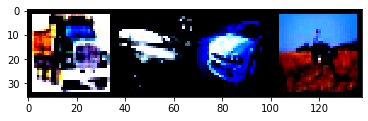

In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()


# print images
imshow(torchvision.utils.make_grid(images[0:4]))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Prediction of sampe test set

In [16]:
images,labels = images.to(device),labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  truck   car   car  bird


# Evaluating Train Accuracy

In [17]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 50000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 50000 train images: 81 %


# Evaluating Test Accuracy

In [18]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


# Evaluating test Accuracy over different classes 

In [19]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images,labels = images.to(device),labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 65 %
Accuracy of   car : 81 %
Accuracy of  bird : 65 %
Accuracy of   cat : 72 %
Accuracy of  deer : 76 %
Accuracy of   dog : 53 %
Accuracy of  frog : 96 %
Accuracy of horse : 86 %
Accuracy of  ship : 76 %
Accuracy of truck : 84 %
